In this example, we will load a CSV file of three axis acceleration data and do some vibration analysis and plotting, all in Python for free!

# Import Libraries
In Python we need to import the libraries we want/need for an application, it isn't all built in like MATLAB - this is the benefit of open source (although at first it seems annoying)!

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
from scipy import signal

# Import CSV File

In [ ]:
from google.colab import files
import os.path

filenames = list(files.upload())
display(filenames)

Saving SCM unit1.csv to SCM unit1 (1).csv


['SCM unit1.csv']

In [ ]:
#df = pd.read_csv('https://info.endaq.com/hubfs/data/surgical-instrument.csv')
df = pd.read_csv(filenames[0])
df

0  -0.470160481
0      0.000016      4.309804
1      0.000032      2.115722
2      0.000048     10.108455
3      0.000064     13.086138
4      0.000080      6.503887
...         ...           ...
99994  1.599920     39.571836
99995  1.599936     40.198726
99996  1.599952     39.650201
99997  1.599968     43.568205
99998  1.599984     46.310812

[99999 rows x 2 columns]

In [ ]:
df.columns = ['Time (s)', 'Accel (g)']

In [ ]:
df = df.set_index('Time (s)')
df

Accel (g)
Time (s)           
0.000016   4.309804
0.000032   2.115722
0.000048  10.108455
0.000064  13.086138
0.000080   6.503887
...             ...
1.599920  39.571836
1.599936  40.198726
1.599952  39.650201
1.599968  43.568205
1.599984  46.310812

[99999 rows x 1 columns]

# Plot Data

## Use Matplotlib (Built Into Pandas)

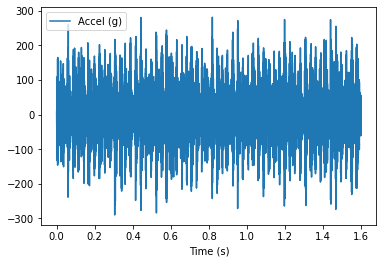

In [ ]:
df.plot()

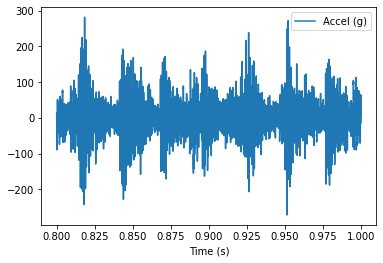

In [ ]:
df[.8:1].plot()

## Interactive Version Using Plotly

In [ ]:
def fig_from_df(df):
    fig = go.Figure()
    for col in df.columns:
      fig.add_trace(go.Scatter(x=df.index,y=df[col],name=col))
    return fig

In [ ]:
fig = fig_from_df(df)
fig.write_html('time-history.html',full_html=False,include_plotlyjs='cdn')
fig.show()

In [ ]:
fig_from_df(df[22:24]).show()

# Generate PSD

In [ ]:
def get_psd(df,bin_width):
  fs = len(df)/(df.index[-1]-df.index[0])
  f, psd = signal.welch(df.to_numpy(), 
                        fs=fs, 
                        nperseg=fs/bin_width,
                        window='hanning',
                        axis=0
                        )

  df_psd = pd.DataFrame(psd,columns=df.columns)
  df_psd.columns
  df_psd['Frequency (Hz)'] = f
  return df_psd.set_index('Frequency (Hz)')

In [ ]:
psd = get_psd(df,1.0)
psd

Accel (g)
Frequency (Hz)           
0.000000         0.007164
1.000010         0.047850
2.000020         0.026340
3.000030         0.002867
4.000040         0.016348
...                   ...
31246.312466     0.001381
31247.312476     0.001130
31248.312486     0.001368
31249.312496     0.001145
31250.312506     0.000389

[31251 rows x 1 columns]

In [ ]:
def get_psd_plot(df_psd):
  fig = fig_from_df(df_psd.iloc[1:])
  fig.update_xaxes(type="log",title_text="Frequency (Hz)")
  fig.update_yaxes(type="log",title_text="Acceleration (g^2/s)")
  return fig

In [ ]:
fig = get_psd_plot(psd)
fig.show()

# Show PSD with Different Linear Spaced Bin Widths

## Change Bin Width to 10 Hz

In [ ]:
get_psd_plot(get_psd(df,10.0)).show()

## Change Bin Width to 0.5 Hz

In [ ]:
get_psd_plot(get_psd(df,.5)).show()

# Save Plot & CSV

In [ ]:
fig.write_html('psd.html',full_html=False,include_plotlyjs='cdn')
psd.to_csv('psd.csv')

# Generate Cumulative RMS from PSD

In [ ]:
def rms_from_psd(df_psd):
    d_f = df_psd.index[1] - df_psd.index[0]
    df_rms = df_psd.copy()
    df_rms = df_rms*d_f
    df_rms = df_rms.cumsum()
    return(df_rms**0.5)

df_rms = rms_from_psd(psd)
fig = fig_from_df(df_rms)
fig.update_xaxes(type="log",title_text="Frequency (Hz)")
fig.update_yaxes(title_text="Acceleration gRMS")

fig.write_html('cum-rms.html',full_html=False,include_plotlyjs='cdn')
df_rms.to_csv('cum-rms.csv')

fig.show()

# Octave Spaced PSD

## Supporting Functions

In [ ]:
def build_oct(start,stop,space):
    a = [start]
    while a[-1] < stop:
        a = np.append(a,[a[-1]*(2**space)])
    df = pd.DataFrame(a,columns=['Frequency (Hz)'])
    df['Lower'] = df['Frequency (Hz)']/(2**(space/2))
    df['Upper'] = df['Frequency (Hz)']*(2**(space/2))
    df['Upper'][df['Upper']>stop]=stop
    df['Frequency (Hz)'][df['Frequency (Hz)']>stop]=stop
    df = df.set_index('Frequency (Hz)')
    return df[df['Lower']<stop]

def add_oct_psd(df_psd,df_oct):
    df_oct_psd = df_oct.drop(['Lower','Upper'], axis=1).copy()
    for name in df_psd.columns:
        df_oct_psd[name]=np.nan
    df_oct_rms = df_oct_psd.copy()
    f_step = df_psd.index[1]-df_psd.index[0]
    for i in range(df_oct.shape[0]):
        f_l = df_oct['Lower'].iloc[i]
        f_u = df_oct['Upper'].iloc[i]
        for j in df_psd.columns:
            d_t = df_psd[j][(df_psd.index>=f_l) & (df_psd.index<f_u)]
            d_t = d_t*f_step
            df_oct_psd[j].iloc[i] = d_t.sum()/(f_u-f_l)
            df_oct_rms[j].iloc[i] = d_t.sum()
    return df_oct_psd, df_oct_rms.cumsum()**0.5

## Do the Thing

In [ ]:
fs = len(df)/(df.index[-1]-df.index[0])

df_oct = build_oct(1,fs/2,1/3)            
df_oct_psd,df_oct_rms = add_oct_psd(psd,df_oct)    

# Get Rid of Values Equal to 0
df_oct_psd = df_oct_psd[(df_oct_psd > 0).any(axis=1)]

get_psd_plot(df_oct_psd).show()

# Demonstrate with Simple Sine Wave

In [ ]:
def build_two_sine_wave(fs,length):
    x = np.arange(0, length, 1/fs)
    y = np.sin(x*7*2*np.pi)+np.sin(x*13*2*np.pi)
    name = str(length) + ' s'
    df =  pd.DataFrame({'Time (s)':x,
                       name:y})
    return df.set_index('Time (s)')
    
fig_from_df(build_two_sine_wave(100,10.0)).show()

## FFT

In [ ]:
from scipy.fft import fft, fftfreq

def get_fft(df):
    N=len(df)
    fs = len(df)/(df.index[-1]-df.index[0])
    
    x_plot= fftfreq(N, 1/fs)[:N//2]
    
    df_fft = pd.DataFrame()
    df_phase = pd.DataFrame()
    for name in df.columns:
        yf = fft(df[name].values) 
        y_plot= 2.0/N * np.abs(yf[0:N//2])
        
        '''
        phase = np.unwrap(2 * np.angle(yf)) / 2 * 180/np.pi
        df_phase = pd.concat([df_phase,
                            pd.DataFrame({'Frequency (Hz)':x_plot[1:],
                                          name:phase[1:n]}).set_index('Frequency (Hz)')],axis=1)
        '''
        df_fft = pd.concat([df_fft,
                            pd.DataFrame({'Frequency (Hz)':x_plot[1:],
                                          name:y_plot[1:]}).set_index('Frequency (Hz)')],axis=1)
    
    return df_fft

In [ ]:
fig_from_df(get_fft(build_two_sine_wave(100,10.0))).show()

In [ ]:
fig_from_df(get_fft(build_two_sine_wave(100,5.5))).show()

## PSD

In [ ]:
psd = get_psd(build_two_sine_wave(100,10.0),1)
fig = fig_from_df(psd)
fig.show()

In [ ]:
psd = get_psd(build_two_sine_wave(100,5.5),1)
fig = fig_from_df(psd)
fig.show()

## FFT from PSD

In [ ]:
def get_fft_from_psd(df,bin_width):
  fs = len(df)/(df.index[-1]-df.index[0])
  f, psd = signal.welch(df.to_numpy(), 
                        fs=fs, 
                        nperseg=fs/bin_width,
                        window='hanning',
                        axis=0,
                        scaling = 'spectrum'
                        )

  df_psd = pd.DataFrame(psd**0.5,columns=df.columns)
  df_psd.columns
  df_psd['Frequency (Hz)'] = f
  return df_psd.set_index('Frequency (Hz)')

In [ ]:
psd = get_fft_from_psd(build_two_sine_wave(100,10.0),1)
fig = fig_from_df(psd)
fig.show()

In [ ]:
psd = get_fft_from_psd(build_two_sine_wave(100,5.5),1)
fig = fig_from_df(psd)
fig.show()

In [ ]:
psd = get_fft_from_psd(build_two_sine_wave(100,5.5),.25)
fig = fig_from_df(psd)
fig.show()